In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import geopandas as gp
plt.rcParams['figure.dpi'] = 300

# 讀取台灣地圖資料
### 欄位
COUNTYCODE, COUNTYID, COUNTYNAME, TOWNCODE, TOWNENG, TOWNID, TOWNNAME, geometry

In [17]:
#全台灣村里界圖
taiwan_villages_shp = gp.read_file("../GeoPandas_GettingStart/town_shp/TOWN_MOI_1060525.shp")

#全台灣鄉鎮市區界圖
taiwan_town_shp = taiwan_villages_shp.dissolve('COUNTYNAME', as_index=False)

# 火災事件資料前處理
1. 讀取、合併各縣市資料
2. "火災原因"關聯分組
3. "鄉鎮市區" column name 字串替換 & 缺字補充

In [18]:
# 1. 讀取、合併各縣市資料

# 建立各縣市火災檔案清單
list_xls_file = []
floder_path = '104年火災事件資料/'
for i in os.listdir(floder_path):
    list_xls_file.append(floder_path+i)
      
# 合併各縣市火災資料
df_taiwan_fire_event = pd.DataFrame()
for xls in list_xls_file:
    df = pd.read_excel(
                  xls, #list_xls_file[3],
                  skiprows=[0] #這份文件的 row1 不是 index，是文件名稱，所以要跳過
    )
    #print('{} 案件數量={}, '.format(df_taiwan_fire_event['縣市'].unique(), df_taiwan_fire_event.index.size), end='')
    df_taiwan_fire_event = pd.concat([df_taiwan_fire_event, df])

In [19]:
# 2. "火災原因"關聯分組

# 火災事件關聯分組表
dict_fire_event = {
    '自殺':['自殺','自焚'],
    '蠟燭':['蠟燭','燈燭'],
    '縱火':['縱火','疑似縱火','人為縱火'],
    '瓦斯':['瓦斯','瓦斯外洩','瓦斯漏氣或爆炸','洩漏液化石油氣','洩漏液化瓦斯','瓦斯漏氣爆炸','瓦斯灌充填打火機不慎'],
    '機械設備':['機械設備','機械故障'],
    '電氣因素':['電氣因素','電氣因素(不含車輛)'],
    '乾燥作業':['乾燥作業','烘乾機作業不慎','烤火'],
    '敬神祭祖':['敬神祭祖','敬神、祭祖','敬神','祭祖'],
    '爐火烹調':['爐火烹調','爐火不慎','爐火烹調油鍋起火','爐火烹調乾燒'],
    '車輛因素':['車輛因素','車輛電氣因素','車輛機械因素','引擎排煙管高溫','車輛人為疏忽','車輛電氣系統','車輛燃料系統',],
    '燃燒廢棄物':['燃燒廢棄物','燃燒雜草、垃圾','自清','燒廢料','燃燒木材不慎','整地','引燃汽油','引燃枯草'],
    '燃放爆竹煙火':['燃放爆竹','燃放爆竹煙火','施放爆竹煙火'],
    '易燃液體接觸火源':['易燃液體接觸火源','易燃品自燃','化學物品','柴油洩漏接觸熱源','絕緣油接觸高溫','易燃液體'],
    '其他或不明':['其他或不明','其他','其它','原因不明','不明']
}

print("原先所有類別數量 = {}".format(len(df_taiwan_fire_event['起火原因'].unique())))

# 關聯分組字串替換
for key in dict_fire_event:
    df_taiwan_fire_event['起火原因'].replace(
        to_replace = dict_fire_event[key],
        value = key, inplace=True)

df_fire_cause_count = df_taiwan_fire_event.groupby(by = ['起火原因'], squeeze = True).count()
df_fire_cause_count.iloc[:,0:1].sort_values(
                    by = df_fire_cause_count.columns[0],
                    ascending = False)
print("關聯分組類別數量 = {}".format(len(df_fire_cause_count.index.unique())))
print(df_fire_cause_count.index.values)

原先所有類別數量 = 62
關聯分組類別數量 = 25
['乾燥作業' '交通事故' '其他或不明' '天然災害' '敬神掃墓祭祖' '敬神祭祖' '施工不慎' '易燃液體接觸火源' '機械設備'
 '汙泥過熱' '燃放爆竹煙火' '燃燒廢棄物' '爐火烹調' '玩火' '瓦斯' '縱火' '自殺' '菸蒂' '蠟燭' '車輛因素' '遺留火種'
 '除蜂不慎' '電暖器引燃可燃物' '電氣因素' '點蚊香不慎引火']


In [20]:
# 3. "鄉鎮市區" column name 字串替換 & 缺字補充

#'鄉、鎮、市、區'不能 query
df_taiwan_fire_event.rename_axis({'鄉、鎮、市、區':'鄉鎮市區'}, axis=1, inplace=True)

dict_TOWNNAME = {
    '中山區':['中山區','中山'],
    '七堵區':['七堵區','七堵'],
    '中正區':['中正區','中正'],
    '仁愛區':['仁愛區','仁愛'],
    '信義區':['信義區','信義'],
    '安樂區':['安樂區','安樂'],
    '暖暖區':['暖暖區','暖暖'],
    '臺西鄉':['臺西鄉','臺西','台西鄉','台西'],
}

for key in dict_TOWNNAME:
    df_taiwan_fire_event['鄉鎮市區'].replace(
            to_replace = dict_TOWNNAME[key],
            value = key, inplace=True)

In [21]:
# 求兩個資料集的差異
set(df_taiwan_fire_event['鄉鎮市區'].unique()).difference(set(taiwan_town_shp['TOWNNAME']))

{'七股區',
 '三地門鄉',
 '三峽區',
 '三星鄉',
 '三民區',
 '三義鄉',
 '三芝區',
 '三重區',
 '下營區',
 '中區',
 '中和區',
 '中埔鄉',
 '中壢區',
 '中寮鄉',
 '中山區',
 '中正區',
 '中西區',
 '九如鄉',
 '二崙鄉',
 '二林鎮',
 '二水鄉',
 '五峰鄉',
 '五結鄉',
 '五股區',
 '仁德區',
 '仁愛區',
 '仁愛鄉',
 '仁武區',
 '伸港鄉',
 '佳里區',
 '來義鄉',
 '信義區',
 '信義鄉',
 '元長鄉',
 '內埔鄉',
 '內湖區',
 '內門區',
 '八德區',
 '八里區',
 '公館鄉',
 '冬山鄉',
 '前金區',
 '前鎮區',
 '北區',
 '北埔鄉',
 '北屯區',
 '北投區',
 '北斗鎮',
 '北港鎮',
 '北竿鄉',
 '北門區',
 '卑南鄉',
 '卓溪鄉',
 '卓蘭鎮',
 '南化區',
 '南區',
 '南州鄉',
 '南庄鄉',
 '南港區',
 '南澳鄉',
 '口湖鄉',
 '古坑鄉',
 '台南市南區鯤鯓湖南側水道(CTR-CI0031舢舨)',
 '吉安鄉',
 '名間鄉',
 '后里區',
 '和平區',
 '和美鎮',
 '員山鄉',
 '員林市',
 '善化區',
 '四湖鄉',
 '國姓鄉',
 '土城區',
 '土庫鎮',
 '埔心鄉',
 '埔里鎮',
 '埔鹽鄉',
 '埤頭鄉',
 '士林區',
 '壯圍鄉',
 '壽豐鄉',
 '外埔區',
 '大內區',
 '大同區',
 '大同鄉',
 '大園區',
 '大城鄉',
 '大埤鄉',
 '大寮區',
 '大村鄉',
 '大林鎮',
 '大樹區',
 '大武鄉',
 '大湖鄉',
 '大溪區',
 '大甲區',
 '大社區',
 '大里區',
 '大雅區',
 '太平區',
 '太麻里鄉',
 '安南區',
 '安定區',
 '安平區',
 '安樂區',
 '官田區',
 '宜蘭市',
 '寶山鄉',
 '小港區',
 '尖石鄉',
 '屏東市',
 '岡山區',
 '崁頂鄉',
 '崙背鄉',
 '布袋鎮',
 '平溪區',
 '平鎮區',
 '彰化市',
 '後壁區',
 '後龍鎮',
 '復興區',
 '

In [22]:
# df_taiwan_fire_event.sort_values(by='受傷人數', ascending=False)
# taiwan_town_shp[['COUNTYNAME','TOWNNAME']]
# pd.Series(index = df_taiwan_fire_event['起火原因'].unique(),
#           data  = df_taiwan_fire_event.query('縣市=="臺中市" and 鄉鎮市區=="潭子區"')["起火原因"].value_counts()).fillna(0)

In [23]:
# df_raw.query('"潭子"鄉鎮市區')
# df_taichug_region1 = df_taiwan_fire_event.query('"大雅區"==鄉鎮市區 or "神岡區"==鄉鎮市區 or "潭子區"==鄉鎮市區 or "豐原區"==鄉鎮市區')

In [26]:
# 嘗試合併兩邊的表

# 各鄉鎮市區起火原因表
df_town_fire_cause = pd.crosstab(index=[df_taiwan_fire_event['縣市'],
#                                         df_taiwan_fire_event['鄉鎮市區']
                                       ],
                                columns=df_taiwan_fire_event["起火原因"])

df_test = taiwan_town_shp[['COUNTYNAME',
#                            'TOWNNAME',
                           'geometry']]
df_test = df_test.merge(right = df_town_fire_cause,
                        left_on = ['COUNTYNAME',
#                                    'TOWNNAME'
                                  ],
                        right_index = True,
                        how = 'left'
             )

In [ ]:
# 各鄉鎮市區縱火與自殺火災排名表
# df_test[['COUNTYNAME','TOWNNAME','縱火','自殺']].sort_values(by = ['縱火'], ascending = False)

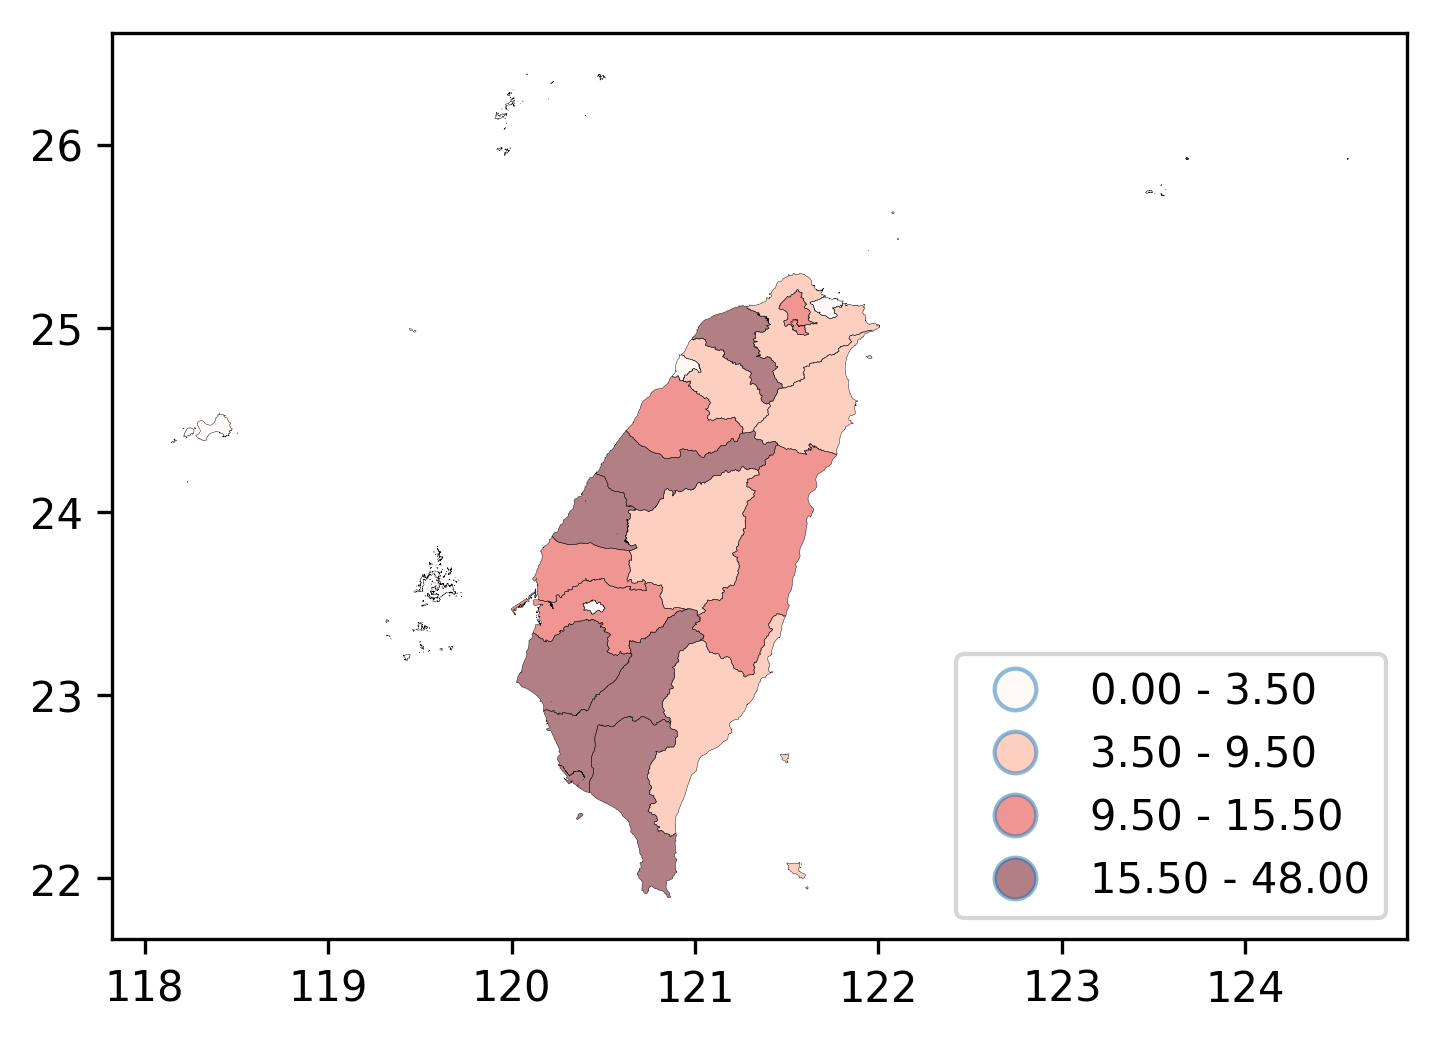

In [40]:
ax = df_test.plot(
    linewidth = 0.1,
    cmap = plt.cm.Reds, #指定顏色
    column = '縱火', #指定從自身的這個 column 讀取顏色深度,
    legend = True, k = 4, scheme = 'Quantiles'
)
# ax.legend(df_test['自殺'])
plt.show()